In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import haversine_distances

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 28.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 32.2 MB/s 
     |████████████████████████████████| 1.8 MB 64.4 MB/s 
     |████████████████████████████████| 103 kB 75.8 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    cat_num = 200
    feat_columns = ['name', 'address', 'city', 
                'state', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):
    latlon_values = data.loc[df['id'], ['latitude', 'longitude']].values
    matlatlon_values = data.loc[df['match_id'], ['latitude', 'longitude']].values
    distances = []
    cnt = 0
    for latlon, matlatlon in tqdm(zip(latlon_values, matlatlon_values)):
        distances.append(haversine_distances([latlon, matlatlon])[0, 1])

        cnt += 1
        if cnt % 1000000 == 0:
            gc.collect()
    
    df['distance'] = distances

    del latlon_values, matlatlon_values, distances
    gc.collect()

    cat_values = data.loc[df['id']]['categories'].values.astype(str)
    matcat_values = data.loc[df['match_id']]['categories'].values.astype(str)
    cat_dist_percentile1 = []
    cat_dist_percentile2 = []

    cat2dist_distances_num = cat2dist['distances_num'].values
    cat2dist_distances = cat2dist['distances'].values
    cat2idx = {cat:i for i, cat in enumerate(cat2dist.index)}

    cnt = 0
    for s, distance in tqdm(zip(cat_values, df['distance'].values)):
        max_cat = 'unknown'
        max_cat_num = CFG.cat_num
        for cat in s.split(', '):
            if cat != 'nan' and cat in categories:
                cat_num = cat2dist_distances_num[cat2idx[cat]]
                if cat_num > max_cat_num:
                    max_cat_num = cat_num
                    max_cat = cat
        cat_distances = cat2dist_distances[cat2idx[max_cat]]
        cat_dist_percentile1.append((cat_distances < distance).astype(int).mean())

        cnt += 1
        if cnt % 1000000 == 0:
            gc.collect()

    gc.collect()
    
    cnt = 0
    for s, distance in tqdm(zip(matcat_values, df['distance'].values)):
        max_cat = 'unknown'
        max_cat_num = CFG.cat_num
        for cat in s.split(', '):
            if cat != 'nan' and cat in categories:
                cat_num = cat2dist_distances_num[cat2idx[cat]]
                if cat_num > max_cat_num:
                    max_cat_num = cat_num
                    max_cat = cat
        cat_distances = cat2dist_distances[cat2idx[max_cat]]
        cat_dist_percentile2.append((cat_distances < distance).astype(int).mean())

        cnt += 1
        if cnt % 1000000 == 0:
            gc.collect()
    
    gc.collect()

    df['cat_dist_percentile1'] = cat_dist_percentile1
    df['cat_dist_percentile2'] = cat_dist_percentile2

    del cat_values, matcat_values, cat_dist_percentile1, cat_dist_percentile2, cat2dist_distances_num, cat2dist_distances
    gc.collect()

    for col in tqdm(CFG.feat_columns):
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        vc = data[col].value_counts()
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
        gc.collect()
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 100000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

Calculate distances between matched entities

In [ ]:
cat2dis_data = data[data['set'] == 0]

In [ ]:
poi2distances = {}
all_distances = []
for poi, df in tqdm(cat2dis_data[["latitude", "longitude", "point_of_interest"]].groupby("point_of_interest"),
                    total=cat2dis_data["point_of_interest"].nunique()):
    if len(df) == 1:
        # no matches
        continue
        
    distances = []
    distances_mat = haversine_distances(df[["latitude", "longitude"]].values)
    for i in range(len(df) - 1):
        for j in range(i + 1, len(df)):
            # haversine distance -> meters
            distances.append(distances_mat[i, j])
            all_distances.append(distances_mat[i, j])
    poi2distances[poi] = distances

  0%|          | 0/369986 [00:00<?, ?it/s]

In [ ]:
poi2distances_df = pd.DataFrame({
    "point_of_interest": list(poi2distances.keys()),
    "distances": list(poi2distances.values())
})
poi2distances_df.head()

,point_of_interest,distances
0,P_0000c58a53df6d,[0.002288377953984225]
1,P_00010455487fcf,[0.0004857766987403706]
2,P_000116a2d0a467,[0.0003377296227570637]
3,P_00019fb954100b,[0.016459019668901686]
4,P_00027058a58996,[0.00028316048697444137]


Split categories, merge with distances per point_of_interest

In [ ]:
cat2dis_data["categories"] = cat2dis_data["categories"].fillna("").map(lambda x: x.split(", "))
cat2dis_data_ = cat2dis_data[["id", "name", "categories", "point_of_interest"]].merge(
    poi2distances_df, on="point_of_interest", how="inner")
cat2dis_data_["median_distances"] = cat2dis_data_["distances"].map(np.median)
cat2dis_data_.head()

,id,name,categories,point_of_interest,distances,median_distances
0,E_000002eae2a589,Carioca Manero,[Brazilian Restaurants],P_d82910d8382a83,[0.0002270160308670873],0.000227
1,E_e80db432029aea,Carioca Manero,"[Bars, Snack Places]",P_d82910d8382a83,[0.0002270160308670873],0.000227
2,E_000023d8f4be44,Island Spa,[Spas],P_020de174484ec6,[0.0007648195740532826],0.000765
3,E_12453effe251db,Island Spa Theater,[Spas],P_020de174484ec6,[0.0007648195740532826],0.000765
4,E_0000d9e584ed9f,Signature Properties Savannah,[Real Estate Offices],P_af856e3abdcebc,[0.00463056196777935],0.004631


Aggregate distances for each categories

In [ ]:
# make each row has only one category
exploded = cat2dis_data_.explode("categories").drop_duplicates(["point_of_interest", "categories"])
exploded.head()

,id,name,categories,point_of_interest,distances,median_distances
0,E_000002eae2a589,Carioca Manero,Brazilian Restaurants,P_d82910d8382a83,[0.0002270160308670873],0.000227
1,E_e80db432029aea,Carioca Manero,Bars,P_d82910d8382a83,[0.0002270160308670873],0.000227
1,E_e80db432029aea,Carioca Manero,Snack Places,P_d82910d8382a83,[0.0002270160308670873],0.000227
2,E_000023d8f4be44,Island Spa,Spas,P_020de174484ec6,[0.0007648195740532826],0.000765
4,E_0000d9e584ed9f,Signature Properties Savannah,Real Estate Offices,P_af856e3abdcebc,[0.00463056196777935],0.004631


In [ ]:
cat2dist = exploded.groupby("categories")['distances'].apply(lambda x: np.array(list(itertools.chain.from_iterable(x))))
cat2dist = cat2dist.reset_index()
cat2dist.loc[0, 'categories'] = 'unknown'
cat2dist['distances'][0] = np.array(all_distances)
cat2dist['distances_num'] = cat2dist['distances'].map(len)

In [ ]:
cat2dist.head()

,categories,distances,distances_num
0,unknown,"[0.002288377953984225, 0.0004857766987403706, ...",488144
1,ATMs,"[0.0, 0.0005935208131384233, 0.008514918716458...",1231
2,Acai Houses,"[0.001365053899785685, 0.021202317098512818, 0...",14
3,Accessories Stores,"[8.001115039381182e-06, 0.11833767331271419, 0...",634
4,Acehnese Restaurants,"[0.0011796681951925748, 0.00016238913050424747...",110


In [ ]:
del cat2dis_data, cat2dis_data_, poi2distances_df, exploded
gc.collect()

200

In [ ]:
categories = set(cat2dist['categories'])
cat2dist = cat2dist.set_index('categories')

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
features = ['distance', 'cat_dist_percentile1', 'cat_dist_percentile2', 'kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

63
['distance', 'cat_dist_percentile1', 'cat_dist_percentile2', 'kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'categories_CE_1', 'categories_CE_2'

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0423512
[100]	valid_0's binary_logloss: 0.0398144
[150]	valid_0's binary_logloss: 0.0386594
[200]	valid_0's binary_logloss: 0.0379523
[250]	valid_0's binary_logloss: 0.037379
[300]	valid_0's binary_logloss: 0.0369824
[350]	valid_0's binary_logloss: 0.0365565
[400]	valid_0's binary_logloss: 0.0362429
[450]	valid_0's binary_logloss: 0.0359614
[500]	valid_0's binary_logloss: 0.0356652
[550]	valid_0's binary_logloss: 0.0353825
[600]	valid_0's binary_logloss: 0.0351537
[650]	valid_0's binary_logloss: 0.0349183
[700]	valid_0's binary_logloss: 0.0346998
[750]	valid_0's binary_logloss: 0.0345235
[800]	valid_0's binary_logloss: 0.0342711
[850]	valid_0's binary_logloss: 0.0341126
[900]	valid_0's binary_logloss: 0.0339587
[950]	valid_0's binary_logloss: 0.0338125
[1000]	valid_0's binary_logloss: 0.0336959
[1050]	valid_0's binary_logloss: 0.0335792
[1100]	valid_0's binary_logloss: 0.0334435
[1150]	valid_0's binary_logloss: 0.0333246
[1200]	valid_0's binary_logloss:

In [ ]:
del train_data
gc.collect()

85

#Check Feature Importances

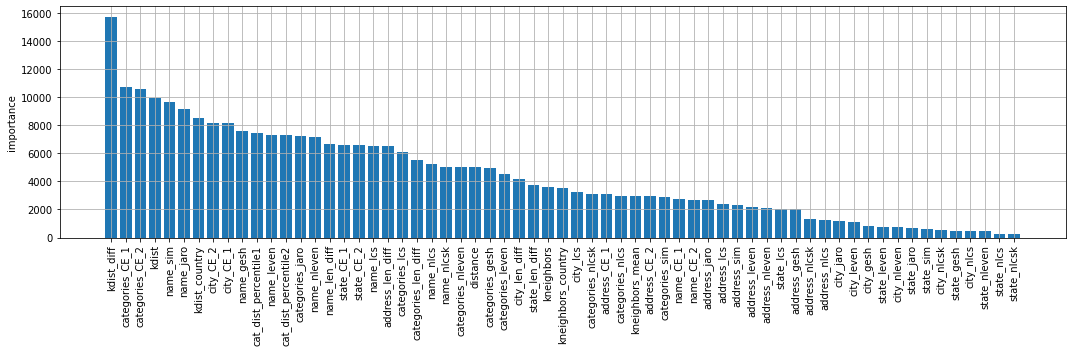

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 26.5 MB/s 
     |████████████████████████████████| 81 kB 11.6 MB/s 
     |████████████████████████████████| 210 kB 82.4 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 112 kB 80.6 MB/s 
     |████████████████████████████████| 146 kB 64.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=236f4e68b7184ac8012b97a55f913ceac03c141f002e8f401a482428698fde8f
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [37]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-29 01:40:24,975] A new study created in memory with name: no-name-36ed02b4-4307-4702-921f-d0bb8d9ad0ed
[I 2022-05-29 01:40:51,717] Trial 0 finished with value: 0.7823253197780821 and parameters: {'threshold': 0.07728720552456592}. Best is trial 0 with value: 0.7823253197780821.


CV: 0.782325


[I 2022-05-29 01:41:12,026] Trial 1 finished with value: 0.8418308347501751 and parameters: {'threshold': 0.5838303476256929}. Best is trial 1 with value: 0.8418308347501751.


CV: 0.841831


[I 2022-05-29 01:41:30,735] Trial 2 finished with value: 0.8395541665770022 and parameters: {'threshold': 0.7046903421381351}. Best is trial 1 with value: 0.8418308347501751.


CV: 0.839554


[I 2022-05-29 01:41:49,282] Trial 3 finished with value: 0.8360803171977073 and parameters: {'threshold': 0.7741960688768638}. Best is trial 1 with value: 0.8418308347501751.


CV: 0.836080


[I 2022-05-29 01:42:10,287] Trial 4 finished with value: 0.8042067183802614 and parameters: {'threshold': 0.12664111337075168}. Best is trial 1 with value: 0.8418308347501751.


CV: 0.804207


[I 2022-05-29 01:42:29,011] Trial 5 finished with value: 0.8415127301866229 and parameters: {'threshold': 0.6320103623533959}. Best is trial 1 with value: 0.8418308347501751.


CV: 0.841513


[I 2022-05-29 01:42:51,570] Trial 6 finished with value: 0.8412579940357038 and parameters: {'threshold': 0.642756782080135}. Best is trial 1 with value: 0.8418308347501751.


CV: 0.841258


[I 2022-05-29 01:43:09,515] Trial 7 finished with value: 0.7561423166252064 and parameters: {'threshold': 0.9901474287768941}. Best is trial 1 with value: 0.8418308347501751.


CV: 0.756142


[I 2022-05-29 01:43:28,615] Trial 8 finished with value: 0.8409493725458428 and parameters: {'threshold': 0.47775002851366144}. Best is trial 1 with value: 0.8418308347501751.


CV: 0.840949


[I 2022-05-29 01:43:48,673] Trial 9 finished with value: 0.8400685896927169 and parameters: {'threshold': 0.44569158853301494}. Best is trial 1 with value: 0.8418308347501751.


CV: 0.840069


[I 2022-05-29 01:44:08,168] Trial 10 finished with value: 0.8341821831066919 and parameters: {'threshold': 0.3223072666899577}. Best is trial 1 with value: 0.8418308347501751.


CV: 0.834182


[I 2022-05-29 01:44:26,681] Trial 11 finished with value: 0.8286748141945557 and parameters: {'threshold': 0.8507199751516784}. Best is trial 1 with value: 0.8418308347501751.


CV: 0.828675


[I 2022-05-29 01:44:46,563] Trial 12 finished with value: 0.8417152212643456 and parameters: {'threshold': 0.6145783095896876}. Best is trial 1 with value: 0.8418308347501751.


CV: 0.841715


[I 2022-05-29 01:45:05,988] Trial 13 finished with value: 0.8354370461517807 and parameters: {'threshold': 0.3407199269817788}. Best is trial 1 with value: 0.8418308347501751.


CV: 0.835437


[I 2022-05-29 01:45:25,041] Trial 14 finished with value: 0.8419842143041963 and parameters: {'threshold': 0.5586007229791099}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841984


[I 2022-05-29 01:45:45,389] Trial 15 finished with value: 0.8291260237153862 and parameters: {'threshold': 0.2645941878640913}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.829126


[I 2022-05-29 01:46:04,438] Trial 16 finished with value: 0.8418127204801671 and parameters: {'threshold': 0.5251036245824436}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841813


[I 2022-05-29 01:46:23,845] Trial 17 finished with value: 0.8254812918427206 and parameters: {'threshold': 0.8723562931020109}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.825481


[I 2022-05-29 01:46:42,944] Trial 18 finished with value: 0.8417915396706044 and parameters: {'threshold': 0.5204209496721452}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841792


[I 2022-05-29 01:47:04,587] Trial 19 finished with value: 0.8385449301191961 and parameters: {'threshold': 0.4021950897555161}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.838545


[I 2022-05-29 01:47:24,153] Trial 20 finished with value: 0.8209030741852181 and parameters: {'threshold': 0.20071709443965907}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.820903


[I 2022-05-29 01:47:44,286] Trial 21 finished with value: 0.84194259975551 and parameters: {'threshold': 0.5499944794536247}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841943


[I 2022-05-29 01:48:03,362] Trial 22 finished with value: 0.8418644837690089 and parameters: {'threshold': 0.5740195012994366}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841864


[I 2022-05-29 01:48:22,032] Trial 23 finished with value: 0.8383203069904287 and parameters: {'threshold': 0.7329316363784436}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.838320


[I 2022-05-29 01:48:41,134] Trial 24 finished with value: 0.8381391239161033 and parameters: {'threshold': 0.392692151575466}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.838139


[I 2022-05-29 01:49:01,017] Trial 25 finished with value: 0.8418382446963515 and parameters: {'threshold': 0.5824418006131231}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841838


[I 2022-05-29 01:49:20,120] Trial 26 finished with value: 0.8413717282283565 and parameters: {'threshold': 0.4993222998141624}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841372


[I 2022-05-29 01:49:39,740] Trial 27 finished with value: 0.8399755711447856 and parameters: {'threshold': 0.690593414990421}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.839976


[I 2022-05-29 01:49:58,222] Trial 28 finished with value: 0.8302981458608246 and parameters: {'threshold': 0.8373586284372482}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.830298


[I 2022-05-29 01:50:22,185] Trial 29 finished with value: 0.6269864851861153 and parameters: {'threshold': 0.007396130563665726}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.626986


[I 2022-05-29 01:50:41,093] Trial 30 finished with value: 0.8419259279556628 and parameters: {'threshold': 0.5696446810489059}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841926


[I 2022-05-29 01:51:03,075] Trial 31 finished with value: 0.8419251136172976 and parameters: {'threshold': 0.5491638105060606}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841925


[I 2022-05-29 01:51:22,291] Trial 32 finished with value: 0.8393552628734304 and parameters: {'threshold': 0.42173076279059385}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.839355


[I 2022-05-29 01:51:42,357] Trial 33 finished with value: 0.8418270717964434 and parameters: {'threshold': 0.536017785813523}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841827


[I 2022-05-29 01:52:01,168] Trial 34 finished with value: 0.8403197980882 and parameters: {'threshold': 0.6785791260662066}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.840320


[I 2022-05-29 01:52:20,893] Trial 35 finished with value: 0.8362916459459191 and parameters: {'threshold': 0.7717045374510705}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.836292


[I 2022-05-29 01:52:39,781] Trial 36 finished with value: 0.8419138719349687 and parameters: {'threshold': 0.5700677907694264}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841914


[I 2022-05-29 01:52:58,803] Trial 37 finished with value: 0.8405432644909587 and parameters: {'threshold': 0.46196318753577015}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.840543


[I 2022-05-29 01:53:18,783] Trial 38 finished with value: 0.8412192641823729 and parameters: {'threshold': 0.6443468908741082}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841219


[I 2022-05-29 01:53:37,958] Trial 39 finished with value: 0.8360498240697395 and parameters: {'threshold': 0.35117148537036447}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.836050


[I 2022-05-29 01:53:57,685] Trial 40 finished with value: 0.8372438569756623 and parameters: {'threshold': 0.7542775410973188}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.837244


[I 2022-05-29 01:54:16,674] Trial 41 finished with value: 0.8419368700726265 and parameters: {'threshold': 0.5642235949810163}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841937


[I 2022-05-29 01:54:36,629] Trial 42 finished with value: 0.8416861408522893 and parameters: {'threshold': 0.6221972698983829}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841686


[I 2022-05-29 01:54:55,527] Trial 43 finished with value: 0.8419581323485171 and parameters: {'threshold': 0.5552754810962254}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841958


[I 2022-05-29 01:55:14,771] Trial 44 finished with value: 0.8407781113226056 and parameters: {'threshold': 0.4712120360993949}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.840778


[I 2022-05-29 01:55:34,740] Trial 45 finished with value: 0.8403947671279892 and parameters: {'threshold': 0.6765079975786386}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.840395


[I 2022-05-29 01:55:53,552] Trial 46 finished with value: 0.8418393266714088 and parameters: {'threshold': 0.6083184975369655}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841839


[I 2022-05-29 01:56:12,729] Trial 47 finished with value: 0.8411947078556413 and parameters: {'threshold': 0.4900279085638283}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841195


[I 2022-05-29 01:56:32,488] Trial 48 finished with value: 0.8410523133847859 and parameters: {'threshold': 0.6527729768404124}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841052


[I 2022-05-29 01:56:53,000] Trial 49 finished with value: 0.8307749064468678 and parameters: {'threshold': 0.2810775891136405}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.830775


[I 2022-05-29 01:57:12,270] Trial 50 finished with value: 0.8395212913740457 and parameters: {'threshold': 0.42700454475578614}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.839521


[I 2022-05-29 01:57:31,259] Trial 51 finished with value: 0.8419408435332144 and parameters: {'threshold': 0.5499655643976002}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841941


[I 2022-05-29 01:57:50,249] Trial 52 finished with value: 0.8418566672728621 and parameters: {'threshold': 0.6025153840595788}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841857


[I 2022-05-29 01:58:10,399] Trial 53 finished with value: 0.8418245702434173 and parameters: {'threshold': 0.535632142008374}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841825


[I 2022-05-29 01:58:29,474] Trial 54 finished with value: 0.8414344444398274 and parameters: {'threshold': 0.5034804314098008}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841434


[I 2022-05-29 01:58:49,393] Trial 55 finished with value: 0.8418915693854773 and parameters: {'threshold': 0.5725382113969096}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841892


[I 2022-05-29 01:59:10,210] Trial 56 finished with value: 0.8367671016848984 and parameters: {'threshold': 0.3633109345581116}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.836767


[I 2022-05-29 01:59:29,321] Trial 57 finished with value: 0.8399575437971238 and parameters: {'threshold': 0.44153528660327024}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.839958


[I 2022-05-29 01:59:48,090] Trial 58 finished with value: 0.8393216859279564 and parameters: {'threshold': 0.7121224510661508}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.839322


[I 2022-05-29 02:00:07,107] Trial 59 finished with value: 0.8419533206420355 and parameters: {'threshold': 0.5512886628019414}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841953


[I 2022-05-29 02:00:25,953] Trial 60 finished with value: 0.7621386825841757 and parameters: {'threshold': 0.9878940893239561}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.762139


[I 2022-05-29 02:00:44,992] Trial 61 finished with value: 0.8419675100855033 and parameters: {'threshold': 0.5560627621050873}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841968


[I 2022-05-29 02:01:05,138] Trial 62 finished with value: 0.8419339149971197 and parameters: {'threshold': 0.5474711611579957}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841934


[I 2022-05-29 02:01:25,276] Trial 63 finished with value: 0.841366569721883 and parameters: {'threshold': 0.4993957491715353}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841367


[I 2022-05-29 02:01:44,183] Trial 64 finished with value: 0.8417464418898878 and parameters: {'threshold': 0.6138106940853307}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841746


[I 2022-05-29 02:02:03,080] Trial 65 finished with value: 0.8408245780564647 and parameters: {'threshold': 0.6612432104910365}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.840825


[I 2022-05-29 02:02:22,173] Trial 66 finished with value: 0.8404788533396313 and parameters: {'threshold': 0.4591017487797864}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.840479


[I 2022-05-29 02:02:42,280] Trial 67 finished with value: 0.8378088444454171 and parameters: {'threshold': 0.38473211729975476}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.837809


[I 2022-05-29 02:03:03,009] Trial 68 finished with value: 0.8417898985665874 and parameters: {'threshold': 0.5240659244764893}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841790


[I 2022-05-29 02:03:22,703] Trial 69 finished with value: 0.8394743729285146 and parameters: {'threshold': 0.707196391009294}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.839474


[I 2022-05-29 02:03:42,674] Trial 70 finished with value: 0.8418390869675749 and parameters: {'threshold': 0.5907457964355403}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841839


[I 2022-05-29 02:04:01,644] Trial 71 finished with value: 0.8419298345528726 and parameters: {'threshold': 0.5479831436428588}. Best is trial 14 with value: 0.8419842143041963.


CV: 0.841930


[I 2022-05-29 02:04:20,711] Trial 72 finished with value: 0.841987100501198 and parameters: {'threshold': 0.557378657972568}. Best is trial 72 with value: 0.841987100501198.


CV: 0.841987


[I 2022-05-29 02:04:39,784] Trial 73 finished with value: 0.8409968137884601 and parameters: {'threshold': 0.4810623390231941}. Best is trial 72 with value: 0.841987100501198.


CV: 0.840997


[I 2022-05-29 02:04:59,710] Trial 74 finished with value: 0.8412231542558226 and parameters: {'threshold': 0.6441451891135299}. Best is trial 72 with value: 0.841987100501198.


CV: 0.841223


[I 2022-05-29 02:05:18,930] Trial 75 finished with value: 0.8415775088829073 and parameters: {'threshold': 0.5087367640094655}. Best is trial 72 with value: 0.841987100501198.


CV: 0.841578


[I 2022-05-29 02:05:38,865] Trial 76 finished with value: 0.8419505339927844 and parameters: {'threshold': 0.5672550977823143}. Best is trial 72 with value: 0.841987100501198.


CV: 0.841951


[I 2022-05-29 02:05:58,913] Trial 77 finished with value: 0.841826574420208 and parameters: {'threshold': 0.589610565681919}. Best is trial 72 with value: 0.841987100501198.


CV: 0.841827


[I 2022-05-29 02:06:17,824] Trial 78 finished with value: 0.8415462289404209 and parameters: {'threshold': 0.6291703208757125}. Best is trial 72 with value: 0.841987100501198.


CV: 0.841546


[I 2022-05-29 02:06:36,877] Trial 79 finished with value: 0.8418172292601555 and parameters: {'threshold': 0.5264935259189077}. Best is trial 72 with value: 0.841987100501198.


CV: 0.841817


[I 2022-05-29 02:06:56,091] Trial 80 finished with value: 0.839055199351097 and parameters: {'threshold': 0.41408231533507556}. Best is trial 72 with value: 0.841987100501198.


CV: 0.839055


[I 2022-05-29 02:07:16,978] Trial 81 finished with value: 0.8419682591950799 and parameters: {'threshold': 0.5595460951626532}. Best is trial 72 with value: 0.841987100501198.


CV: 0.841968


[I 2022-05-29 02:07:35,923] Trial 82 finished with value: 0.8419968439834845 and parameters: {'threshold': 0.5583059052149972}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841997


[I 2022-05-29 02:07:55,920] Trial 83 finished with value: 0.8418439419193745 and parameters: {'threshold': 0.5870135654941059}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841844


[I 2022-05-29 02:08:16,244] Trial 84 finished with value: 0.8409788357300247 and parameters: {'threshold': 0.4791579867741475}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.840979


[I 2022-05-29 02:08:35,198] Trial 85 finished with value: 0.8417298971823209 and parameters: {'threshold': 0.6150558576773832}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841730


[I 2022-05-29 02:08:54,274] Trial 86 finished with value: 0.8419512808250118 and parameters: {'threshold': 0.5639320830973131}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841951


[I 2022-05-29 02:09:13,250] Trial 87 finished with value: 0.8417086047180243 and parameters: {'threshold': 0.5162190051703747}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841709


[I 2022-05-29 02:09:33,239] Trial 88 finished with value: 0.8400891879096368 and parameters: {'threshold': 0.44707755718260617}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.840089


[I 2022-05-29 02:09:52,208] Trial 89 finished with value: 0.8419355857245003 and parameters: {'threshold': 0.5649113855271567}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841936


[I 2022-05-29 02:10:11,889] Trial 90 finished with value: 0.8407753508175063 and parameters: {'threshold': 0.6650730485487173}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.840775


[I 2022-05-29 02:10:31,972] Trial 91 finished with value: 0.8419465436159056 and parameters: {'threshold': 0.5617405198290023}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841947


[I 2022-05-29 02:10:51,003] Trial 92 finished with value: 0.8419094982695152 and parameters: {'threshold': 0.6050350302813754}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841909


[I 2022-05-29 02:11:10,844] Trial 93 finished with value: 0.8414979987373998 and parameters: {'threshold': 0.6337279934546046}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841498


[I 2022-05-29 02:11:30,911] Trial 94 finished with value: 0.8419659631016708 and parameters: {'threshold': 0.5637445467734506}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841966


[I 2022-05-29 02:11:50,872] Trial 95 finished with value: 0.8072354261245873 and parameters: {'threshold': 0.1367318856876234}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.807235


[I 2022-05-29 02:12:09,842] Trial 96 finished with value: 0.8417918631944913 and parameters: {'threshold': 0.5223529425254669}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841792


[I 2022-05-29 02:12:28,731] Trial 97 finished with value: 0.841192148110585 and parameters: {'threshold': 0.4910846921879461}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841192


[I 2022-05-29 02:12:48,593] Trial 98 finished with value: 0.8418284769943617 and parameters: {'threshold': 0.5895731743020292}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841828


[I 2022-05-29 02:13:07,672] Trial 99 finished with value: 0.8418438760719626 and parameters: {'threshold': 0.5370381460616998}. Best is trial 82 with value: 0.8419968439834845.


CV: 0.841844


In [38]:
threshold = study.best_params['threshold']
threshold

0.5583059052149972

In [39]:
study.best_value

0.8419968439834845

In [40]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.841997


# 間違っているものの中身を見る

In [41]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [42]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,cat_dist_percentile1,cat_dist_percentile2,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,125842.000000,125842.000000,121942.000000,121942.000000,116611.000000,129842.000000,129842.0,129842.000000,129842.000000,129842.000000,...,96093.000000,96093.000000,96093.000000,109860.000000,110009.000000,129842.000000,96093.000000,96093.000000,96093.000000,1.298420e+05
mean,0.006649,6.350392,0.003527,6.384453,0.431770,6.655331,1.0,0.005581,0.280040,0.280365,...,12.592218,0.674267,9.132549,5608.509712,5613.767746,9.204487,0.537303,0.581231,0.582294,1.854022e-01
std,0.054711,5.268080,0.023907,5.278973,2.464634,5.325331,0.0,0.043930,0.216749,0.216808,...,11.704506,0.243857,7.383404,6758.213067,6761.725920,11.102659,0.353745,0.330610,0.330168,1.735964e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.425654e-11
25%,0.000456,2.000000,0.000341,2.000000,0.005742,2.000000,1.0,0.000358,0.098960,0.099479,...,0.000000,0.483333,4.000000,757.000000,757.000000,0.000000,0.000000,0.285714,0.285714,2.598423e-02
50%,0.001148,5.000000,0.000883,5.000000,0.057780,5.000000,1.0,0.000945,0.237138,0.237375,...,12.000000,0.582888,7.000000,2892.000000,2892.000000,6.000000,0.714286,0.483871,0.482759,1.305837e-01
75%,0.003121,10.000000,0.002403,10.000000,0.320467,10.500000,1.0,0.002632,0.420546,0.420357,...,17.000000,1.000000,12.000000,7208.000000,7208.000000,13.000000,0.823529,1.000000,1.000000,3.248132e-01
max,4.310371,19.000000,2.388985,19.000000,214.206825,19.000000,1.0,2.960282,1.000000,1.000000,...,87.000000,1.000000,68.000000,25481.000000,25481.000000,91.000000,1.000000,1.000000,1.000000,5.582998e-01


In [43]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
8324633,E_9e64e58319f617,E_6b30751522d887,0.001674,14.0,P_9357bd3b188c7b,0.000120,1.0,1.295904e+01,7.5,1,...,NaN,NaN,NaN,NaN,3253.0,2,NaN,NaN,NaN,0.002490
1536003,E_b248401c5de2d3,E_a395d23d0ec44d,0.000375,2.0,P_eed0183af50a4c,0.000366,2.0,2.207264e-02,2.0,1,...,16.0,0.524471,9.0,2042.0,52.0,10,0.666667,0.375000,0.642857,0.200467
2026065,E_8ec068644c3c2f,E_6a52b3c12032ef,0.000705,3.0,P_b3311fbc6c1101,0.000608,11.0,1.582668e-01,7.0,1,...,10.0,0.844737,9.0,2445.0,3815.0,7,0.526316,0.473684,0.750000,0.142809
957663,E_ae496ce5a6919a,E_0cd3eb929ba90b,0.000239,1.0,P_06c9300027628b,0.000208,1.0,1.474440e-01,1.0,1,...,21.0,0.386667,5.0,1200.0,10.0,9,0.840000,0.200000,0.312500,0.019130
7733794,E_94d1ba28ac83ef,E_407eeb945913ec,0.001567,13.0,P_ac222005729063,0.001567,13.0,1.251377e-07,13.0,1,...,31.0,0.557364,13.0,1207.0,3651.0,23,0.720930,0.650000,0.302326,0.531826
1074777,E_e300aa03c6c922,E_dc5b48de022f55,0.000550,1.0,P_b2cd3ed321adef,0.000545,1.0,9.785765e-03,1.0,1,...,20.0,0.760981,26.0,4964.0,32.0,20,0.434783,0.565217,1.000000,0.498303
1444136,E_8916548776411c,E_c5e355d86e0d17,0.001210,2.0,P_e1e906245263ee,0.001206,2.0,2.938217e-03,2.0,1,...,7.0,0.560606,4.0,7329.0,251.0,7,0.636364,0.363636,1.000000,0.095418
653552,E_25b90e53d3e202,E_a7706683d3c0d7,0.000256,1.0,P_b5bc03b65398ac,0.000253,1.0,1.043925e-02,1.0,1,...,20.0,0.453263,7.0,4.0,16954.0,20,0.740741,1.000000,0.259259,0.069827
1900253,E_56391504eec51a,E_02c5fec9734999,0.000415,3.0,P_6edadd37c47c43,0.000406,3.0,2.369269e-02,3.0,1,...,19.0,0.529321,9.0,46.0,4657.0,15,0.703704,0.750000,0.333333,0.386902
2749469,E_d3eb88cb84890a,E_49ece76ccbb61a,0.000435,4.0,P_bb3e45408f34f9,0.000435,4.0,2.036247e-05,4.0,1,...,6.0,0.531746,3.0,16583.0,3088.0,1,0.857143,0.428571,0.500000,0.278244


In [44]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
47818,E_0ab2e0c1b45f55,Riviera III Apartment,3.117055,101.751852,Jalan Bunga Cempaka 15,Taman Muda,Kuala Lumpur,56100,MY,NaN,NaN,Residential Buildings (Apartments / Condos),P_fe04a652bb3e6a,1,1.0
582494,E_82ef68924f23d1,Reviera III Apartment,3.117366,101.749663,Jalan Bunga Cempaka 15,Taman Muda,Kuala Lumpur,56100,MY,NaN,NaN,Residential Buildings (Apartments / Condos),P_fe04a652bb3e6a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
479278,E_6bb5dbe874e2fc,Santosa hospital,-6.914071,107.602999,Klinik 249 dr Prihariadi SpA,NaN,NaN,NaN,ID,NaN,NaN,Doctor's Offices,P_8529a36d0a3855,4,1.0
557504,E_7d4b1544e66acb,HCU RS Santosa Bandung,-6.915107,107.603785,Jalan Kebon Jati,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_8529a36d0a3855,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
50015,E_0b2f3fd213fcce,İbrahim Temiz Erkek Kuaförü,40.655155,29.273517,NaN,Yalova,NaN,NaN,TR,NaN,NaN,Salons / Barbershops,P_a4943dab79edd0,1,1.0
1001760,E_e10906246a0b93,Berber Ibrahim Abi,40.654917,29.273468,NaN,NaN,NaN,NaN,TR,NaN,NaN,Performing Arts Venues,P_a4943dab79edd0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
473606,E_6a70f5069f2a4f,Ruang Cendrawasih RSUP Karyadi,-6.993366,110.410256,Jl. Dr. Sutomo,Semarang,Central Java,NaN,ID,NaN,NaN,Medical Centers,P_954e1707fa0f9e,4,1.0
660202,E_94576d40f72b75,rs karyadi semarang,-6.995930,110.413667,NaN,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_954e1707fa0f9e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
130393,E_1d3d69f2e27ef5,кафедра РК6 МГТУ им. Н. Э. Баумана,55.766607,37.687629,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_45027185ad27fc,4,1.0
386556,E_56d87e4d90f98b,У Рафика,55.766232,37.686354,2-я Бауманская,NaN,NaN,NaN,RU,NaN,NaN,Fairs,P_45027185ad27fc,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
164045,E_24c65944508b2f,Edifício Solar do Maracanã,-22.902883,-43.255969,"R. Mal. Bittencourt, 57",Rio de Janeiro,RJ,20950-200,BR,NaN,NaN,Residential Buildings (Apartments / Condos),P_37597bfb609a21,1,1.0
358750,E_509fb8bf7e709c,solar do maracanã,-22.903303,-43.253046,Marechal Bitencuort,NaN,NaN,NaN,BR,NaN,NaN,Residential Buildings (Apartments / Condos),P_37597bfb609a21,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
105620,E_17aafa8680d180,Front Gate Sales,37.841967,-77.445000,16000 Theme Park Way,Doswell,VA,23047,US,http://www.kingsdominion.com,8048765000,Theme Parks,P_4c135e2ea9b171,4,1.0
227212,E_32ff09f3053cf4,Kings Dominion,37.841548,-77.445633,16000 Theme Park Way,Doswell,VA,23047,US,http://www.kingsdominion.com,8048765000,"Theme Parks, Theme Park Rides/Attractions",P_4c135e2ea9b171,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
278948,E_3e9eb656adfba1,читальный зал,47.223075,39.715317,NaN,NaN,NaN,NaN,RU,NaN,NaN,"Libraries, College Libraries",P_346b237d61cd5c,4,1.0
582716,E_82fd05ee7efa00,РИНХ,47.223217,39.718165,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Administrative Buildings,P_346b237d61cd5c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
65868,E_0ebed4a8a489f9,Koh-i-noor prodejna,50.067659,14.460134,Vršovická 478/51,Praha,NaN,101 00,CZ,http://www.kin.cz/kontakty/maloobchodni-prodejna,+420296525341,"Arts & Crafts Stores, Knitting Stores, Fabric ...",P_53f2807cf92b4b,1,1.0
539505,E_793e697201badb,KOH-I-NOOR a.s.,50.067927,14.461485,Vrovická 478/51,Praha,Hlavní m?sto Praha,10000,CZ,NaN,+420296525341,Buildings,P_53f2807cf92b4b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
256896,E_39afeac3fbf5f0,Гимназия №1,48.721674,44.520823,"ул. Ткачева, 10а",Волгоград,Волгоградская обл.,400050,RU,http://gimnazia-1.moy.su,8442373767,"Schools, High Schools, College Libraries",P_478a56e3c69253,4,1.0
683691,E_9991d302a8990f,Английский,48.722014,44.520596,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_478a56e3c69253,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
176250,E_2786ae53c2a8b1,Kanarya Çay Evi,39.905697,30.041265,Cerrahlar Pasajı,Bozüyük,Bilecik,NaN,TR,NaN,NaN,Tea Rooms,P_3c10e560f02bcf,1,1.0
431100,E_60e318caaa6a7a,Kanarya Çay Ocağı,39.906530,30.040887,NaN,NaN,NaN,NaN,TR,NaN,NaN,Public Art,P_3c10e560f02bcf,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
720598,E_a1df3d6d147dd4,HAYATİ GENİŞ,39.550198,27.092113,Tekke mahallesi Havran,Havran,Balıkesir,10560,TR,NaN,NaN,Gas Stations,P_8ca42e25877352,4,1.0
1098918,E_f6fce17646c0af,Havran Meslek Yüksekokulu,39.558548,27.084772,NaN,Havran,Balıkesir,10560,TR,http://havran.balikesir.edu.tr,+902664321111,College Academic Buildings,P_8ca42e25877352,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
330725,E_4a552b682733ba,FedEx Field Section 124 Row 1,38.921623,-76.864357,NaN,Hyattsville,MD,20785,US,NaN,NaN,Athletics & Sports,P_33f047175e41c9,4,1.0
507662,E_721fbbdf122991,FedEx Field,38.907733,-76.864301,1600 Fedex Way,Landover,MD,20785,US,http://www.redskins.com,3012766050,Football Stadiums,P_33f047175e41c9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
759333,E_aa9638cd577535,Panin Bank Center Lt. 10,-6.228436,106.799792,Senayan - Jakarta Pusat,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_0423eb97e20fe3,4,1.0
807489,E_b554e12a2b2e7f,Panin Kantor Pusat,-6.228652,106.799400,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_0423eb97e20fe3,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
103524,E_17348f7dd8a29d,Estação Peg-Fácil 910,-20.464521,-54.617022,R. Rui Barbosa,Campo Grande,MS,NaN,BR,NaN,NaN,"Bus Stops, Bus Stations",P_c17683d5a2f21d,2,1.0
716424,E_a0eeaf4b5f7815,Ponto 13,-20.463558,-54.614259,R. 26 de Agosto,Campo Grande,MS,NaN,BR,NaN,NaN,Bus Stations,P_c17683d5a2f21d,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
479770,E_6bd144f054f5bd,"""nasi goreng Kediri \""Tipas Pring\""""",-7.261849,112.795559,NaN,Surabaya,Indonesia,NaN,ID,NaN,NaN,NaN,P_b02c815cac6ab9,2,1.0
588804,E_8457bc9163ec1d,Nasi & Mie Goreng Tepas Areng Kediri,-7.263740,112.795664,Jl. Mulyosari No. 78,surabaya,indonesia,60112,ID,NaN,NaN,Food Trucks,P_b02c815cac6ab9,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
445624,E_642774ec426277,Merajan Agung Puri Agung Peliatan,-8.516930,115.269747,NaN,Ubud,Bali,NaN,ID,NaN,NaN,NaN,P_1782fb5ec8e739,1,1.0
623276,E_8c234dd6870f4c,Puri Agung Peliatan,-8.517618,115.268726,Jl. Cokorda Gede Rai,Ubud,"Bali, Indonesia",80571,ID,NaN,NaN,Art Galleries,P_1782fb5ec8e739,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
34241,E_07aa2c5ee465c5,Sman 7 yogyakarta,-7.81397,110.358860,Jl. MT Haryono no. 47 Yk,NaN,NaN,NaN,ID,NaN,NaN,Residential Buildings (Apartments / Condos),P_c1b65b587e54cf,4,1.0
336285,E_4b93d21cea629d,"kolam 7, sma n 7",-7.81482,110.358893,jl mt haryono 47,yogyakarta,NaN,NaN,ID,NaN,NaN,NaN,P_c1b65b587e54cf,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
476344,E_6b0e62a039d686,Bayada Nurses,27.897992,-82.713951,13773 Icot Blvd.,Clearwater,FL,33760,US,NaN,NaN,Medical Centers,P_8c9a3dd9eb7a90,1,1.0
1100985,E_f775eead4312f1,BAYADA Home Health,27.897379,-82.713967,13630 58th St N Ste 103B,Clearwater,FL,33760,US,https://www.bayada.com/offices/fl/clearwater/1...,7275301201,Medical Centers,P_8c9a3dd9eb7a90,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
53129,E_0be58d4088a9b6,Cafee Nero,41.077055,29.043927,Bebek/istanbul,NaN,NaN,NaN,TR,NaN,NaN,Cafés,P_84a36a502cd1d1,4,1.0
492893,E_6ecedfb0f5cc84,Bebek Cafe Nero,41.077111,29.043382,Bebek,NaN,NaN,NaN,TR,NaN,NaN,Cafeterias,P_84a36a502cd1d1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
588051,E_842e7c6f00c1f9,Konevi Anadolu Lisesi Kütüphanesi,37.897056,32.485042,NaN,NaN,NaN,NaN,TR,NaN,NaN,Libraries,P_5cf3b5cbf696f5,3,1.0
1131703,E_fe64ff539684a4,Konevi Anadolu Lisesi Kantin,37.897453,32.484196,Konya,NaN,NaN,NaN,TR,NaN,NaN,Cafeterias,P_5cf3b5cbf696f5,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
523530,E_75a4d8c5af9dc1,Ruangan Secretary Pemred TransTV,-6.241175,106.830304,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_745299120115a1,4,1.0
1018183,E_e4c14d931f93c9,Studio 15 Trans Tv,-6.241236,106.830942,Jl Kapt. Tendean 12-14A,Jakarta,DKI Jakarta,12790,ID,NaN,NaN,Performing Arts Venues,P_745299120115a1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
100980,E_16a18d5452c558,Fn Al-Multaqa,24.721693,46.789404,NaN,riyadh,NaN,NaN,SA,NaN,NaN,Gyms or Fitness Centers,P_b573fde289bc2c,3,1.0
965996,E_d902518a18c3d5,نادي فن الملتقى|Ladies Gym,24.720251,46.789357,Imam shfee street,Riyadh,Saudi Arabia,NaN,SA,NaN,+966114450853,Gyms or Fitness Centers,P_b573fde289bc2c,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
194004,E_2b883a8f2dbba4,Smart Tower 24th Floor-Smart infinity,14.558703,121.018299,NaN,NaN,NaN,NaN,PH,NaN,NaN,Offices,P_b1c07d3800447a,4,1.0
643807,E_90b9e67aaa0365,Smart Tower- Basement Training Room 7A,14.558604,121.018220,NaN,NaN,NaN,NaN,PH,NaN,NaN,Conference Rooms,P_b1c07d3800447a,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
208332,E_2ec24b065ba98f,Rotibo Suncity Mally,-7.450570,112.712770,Suncity Mall,Sidoarjo,Indonesia,NaN,ID,NaN,NaN,Bakeries,P_b1e0987d4d87d8,1,1.0
823366,E_b8e3d4d76358cd,Rotiboy Bakeshoppe,-7.449686,112.711939,"SunCity Mall, LG #A28",Sidoarjo,Jawa Timur,NaN,ID,http://www.rotiboy.com,318068201,"Bakeries, Cupcake Shops",P_b1e0987d4d87d8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
406861,E_5b7003fd67c3ce,obwaga mgudt,55.697622,37.579425,Проспект 60-летия Октября дом 13,Москва,NaN,117312,RU,NaN,NaN,College Residence Halls,P_b6d52ab546bfa9,2,1.0
427735,E_601c9967bd147b,Общага на Академе!,55.694676,37.581020,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Residence Halls,P_b6d52ab546bfa9,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
251241,E_386a8f3e20d368,X IPS SLA Tompaso,1.189644,124.796188,Tompaso,NaN,NaN,NaN,ID,NaN,NaN,College Classrooms,P_6802dcce63f9d9,4,1.0
965626,E_d8ebe62cfbeb51,Kelas XI IPS B (Social B) SMA Advent Tompaso,1.186906,124.795193,Kampus SLA,Minahasa,Sulawesi Utara,NaN,ID,NaN,NaN,College Classrooms,P_6802dcce63f9d9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
518253,E_747ca7f415c9d9,Beauty Hour,55.650317,37.411089,NaN,NaN,NaN,NaN,RU,NaN,NaN,Nail Salons,P_6d76caf1b470dc,1,1.0
1055405,E_ed2977d056ce16,Пятёрочка,55.650536,37.412199,"ул. 50 лет Октября, 7",Москва,Москва,NaN,RU,https://5ka.ru,88005555505,Supermarkets,P_6d76caf1b470dc,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
566602,E_7f58fbbb195edc,X2 Sma negri 2 tasikmalaya,-7.302549,108.202752,NaN,NaN,NaN,NaN,ID,NaN,NaN,High Schools,P_8a28bea2c00c24,4,1.0
877593,E_c520a4053e8c8b,Lab IPS SMA Negeri 2 Kota Tasikmalaya,-7.297408,108.206029,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_8a28bea2c00c24,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
15546,E_0383597fbd1bd3,Cidade Cenografica flor do caribe,-22.961193,-43.397648,NaN,NaN,NaN,NaN,BR,NaN,NaN,General Entertainment,P_6fa6ec8cfd6d25,4,1.0
352278,E_4f27e9c66b5b18,Restaurante dos Figurantes - PROJAC,-22.958060,-43.401843,NaN,NaN,NaN,NaN,BR,NaN,NaN,Restaurants,P_6fa6ec8cfd6d25,4,1.0


labelが0なのに1と予測しているもの

In [45]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,cat_dist_percentile1,cat_dist_percentile2,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,48957.000000,48957.000000,47535.000000,47535.000000,46287.000000,49722.000000,49722.0,49722.000000,49722.000000,49722.000000,...,40319.000000,40319.000000,40319.000000,44255.000000,44161.00000,49722.000000,40319.000000,40319.000000,40319.000000,49722.000000
mean,0.005917,4.452765,0.002768,4.461260,0.402992,4.681238,0.0,0.004306,0.245357,0.245494,...,10.219574,0.777707,11.180312,5304.248017,5298.58880,8.750915,0.388334,0.726429,0.725868,0.790769
std,0.098820,4.731469,0.011915,4.727778,1.613387,4.845625,0.0,0.033584,0.212064,0.212530,...,12.063743,0.239346,7.750716,6461.746877,6446.17159,11.641548,0.363498,0.325029,0.325796,0.136449
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.558316
25%,0.000290,1.000000,0.000226,1.000000,0.007507,1.000000,0.0,0.000236,0.070012,0.070081,...,0.000000,0.533761,5.000000,597.000000,600.00000,0.000000,0.000000,0.407407,0.400000,0.668936
50%,0.000819,2.000000,0.000626,2.000000,0.065039,2.000000,0.0,0.000675,0.185465,0.185538,...,8.000000,0.876376,10.000000,2854.000000,2854.00000,4.000000,0.450000,1.000000,1.000000,0.792874
75%,0.002670,6.000000,0.002007,6.000000,0.314801,7.000000,0.0,0.002229,0.375463,0.376176,...,16.000000,1.000000,15.000000,6957.000000,6957.00000,14.000000,0.750000,1.000000,1.000000,0.916856
max,11.519732,19.000000,0.715058,19.000000,94.986530,19.000000,0.0,2.216293,1.000000,1.000000,...,82.000000,1.000000,93.000000,25481.000000,25481.00000,87.000000,1.000000,1.000000,1.000000,0.999999


In [46]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
2169513,E_cf2d502a71a8e6,E_7d442bf45741ec,0.001594,3.0,P_1be0a7bac19cdd,0.000777,4.0,1.051365,3.5,0,...,9.0,0.900000,9.0,3080.0,149.0,9,0.500000,0.500000,1.000000,0.918434
1474970,E_96e1aff058b6bf,E_85bf127817f80a,0.000539,2.0,P_f37697c43ec438,0.000303,2.0,0.778332,2.0,0,...,19.0,0.434179,5.0,1565.0,699.0,7,0.826087,0.312500,0.217391,0.888987
3805771,E_aecbe7a645a192,E_4af7b167508e8f,0.004116,6.0,P_cdc5da5d189e41,0.004011,6.0,0.026045,6.0,0,...,0.0,1.000000,7.0,16954.0,16954.0,0,0.000000,1.000000,1.000000,0.612117
895100,E_9232173fe11ff2,E_ad27caca3119fe,0.000200,1.0,P_b6673c5c954fb3,0.000177,1.0,0.131910,1.0,0,...,54.0,0.486033,6.0,1.0,4657.0,47,0.915254,0.500000,0.101695,0.943354
797454,E_665980a3fab2be,E_5af1db52e5f718,0.004619,1.0,P_fa14c6344946e2,0.004607,1.0,0.002800,1.0,0,...,0.0,1.000000,7.0,6411.0,6411.0,0,0.000000,1.000000,1.000000,0.873944
572960,E_019e85dff86c88,E_a7595a40bffc80,0.000238,1.0,P_d3b785340444b3,0.000201,2.0,0.180535,1.5,0,...,8.0,0.518519,2.0,16583.0,11981.0,3,0.888889,0.222222,0.333333,0.962865
907295,E_97a3c648a68b34,E_f5e17db160f156,0.001108,1.0,P_7fcccd0f1766fb,0.000273,1.0,3.051570,1.0,0,...,0.0,1.000000,15.0,1468.0,1468.0,0,0.000000,1.000000,1.000000,0.970586
3287504,E_c5c81c984b4d1c,E_1ce895fd48b7dd,0.000207,5.0,P_23006cd34827b6,0.000196,5.0,0.055245,5.0,0,...,16.0,0.531481,6.0,3789.0,21438.0,2,0.800000,0.333333,0.300000,0.811294
1399596,E_7515ae71fd564a,E_5c1d338a3aa8c8,0.000566,2.0,P_eec409ab7e0fbc,0.000213,2.0,1.655536,2.0,0,...,11.0,0.465608,7.0,610.0,16954.0,11,0.611111,1.000000,0.388889,0.806735
10713854,E_d0a4d13c3c9578,E_f8c88f208adc85,0.001766,18.0,P_94e8755d24492f,0.001332,13.0,0.325902,15.5,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.636390


In [47]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
668069,E_9614de13ba7d25,Gündoğan,37.130547,27.344902,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bays,P_cdacbd3d7dc3d1,1,1.0
786991,E_b0ca1edba9981a,Gundogan liman,37.129627,27.345308,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_210bf670eba142,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
208624,E_2ed1d3431ae04c,JR金沢駅西口バスターミナル 1番乗り場,36.578409,136.649141,堀川新町1,金沢市,石川県,920-0849,JP,NaN,NaN,Bus Stations,P_6963e5308ccee7,0,1.0
482475,E_6c70d8e8d179ef,金沢駅西口高速バス乗り場,36.578612,136.646340,NaN,NaN,NaN,NaN,JP,NaN,NaN,Bus Stations,P_e4bd0c59cc95a3,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
262347,E_3ae87c30d19c51,Lincoln Electric - Consumable Manufacturing,41.691626,-81.312829,6500 Heisley Rd,Mentor,OH,44060,US,NaN,NaN,Factories,P_bd3db330a7745e,0,1.0
731487,E_a44f69fcd0d6ca,Lincoln Electric,41.692065,-81.312200,6500 Heisley Rd,Mentor,OH,44060,US,NaN,NaN,Buildings,P_f200907b0747d2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
880063,E_c5ac108d4abd10,Ruang,-6.874465,107.605444,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_eccc7b5bdb0d76,0,1.0
981800,E_dc8d7fe7edd539,Ruang 2209 Fakultas Hukum Unpar,-6.874590,107.605686,Jl. Ciumbuleuit no. 94,Bandung,Jawa Barat,NaN,ID,NaN,NaN,Colleges & Universities,P_e6198f72ed97d9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
183114,E_29156d2f111107,ePLDT,14.554820,121.024128,Makati Ave,Makati City,Metro Manila,NaN,PH,NaN,NaN,Offices,P_96cf13d8f61d24,1,1.0
550456,E_7bb88f42979f88,PLDT,14.554064,121.023736,"Ramon Cojuangco Bldg, Makati Ave cor dela Rosa St",Makati City,NCR,NaN,PH,http://pldthome.com,NaN,Offices,P_6d6006b65faa6c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
108629,E_185ab44df88c53,Arıkanlar Tekstil,40.206463,29.289511,Barakfaki Sanayi Bölgesi,Bursa,NaN,16400,TR,http://www.arikanlartekstil.com,NaN,Factories,P_6f0b748ba581fa,1,1.0
694054,E_9be51a24eaf374,Epsa Yalıtım,40.206046,29.289323,Barakfakih Sanayi Bölgesi 22.Cad. No:10,Kestel,Bursa,16450,TR,http://www.epsa.com.tr,2243841020,Factories,P_58c0e0baa89679,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
465880,E_68ac5372d3b0a5,Yeniköy Boğaz,40.395268,28.381407,NaN,Karacabey,Bursa,NaN,TR,NaN,NaN,"Other Great Outdoors, Beaches",P_f6f1e5bc9d6ebd,2,1.0
765188,E_abe14ad2c2bde0,Yeniköy Boğaz Etkinlik Alanı,40.395220,28.381546,Boğaz Sahil Yolu,Bayramdere Köyü,Bursa,NaN,TR,NaN,NaN,General Entertainment,P_da0787add4056d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
129137,E_1cf2d0aa773b39,Bnaider (264),28.782696,48.293944,NaN,Kuwait,NaN,NaN,KW,NaN,NaN,"Beaches, Campgrounds, Surf Spots",P_0bdd9d9a4cfe8a,2,1.0
237141,E_353c47c486d162,Shalaih Bnaider 264,28.785168,48.291702,NaN,NaN,NaN,NaN,KW,NaN,NaN,Beaches,P_07ba4acf2ac510,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
463381,E_681a646b4269ff,FB-29,-23.987064,-46.293283,NaN,Guarujá,SP,NaN,BR,NaN,NaN,Boats or Ferries,P_1ac7ab9da4dee8,0,1.0
1103733,E_f815f980515c0b,Balsa FB-24,-23.986795,-46.293451,NaN,NaN,NaN,NaN,BR,NaN,NaN,Boats or Ferries,P_a652783428bf0f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
211770,E_2f8b1e338e061f,Geneva Lake,42.564503,-88.504120,NaN,Lake Geneva,WI,53147,US,NaN,NaN,Lakes,P_61bdc61364940c,1,1.0
909484,E_cc51f198360b14,Lake Geneva Waterfront,42.589479,-88.433973,Wrigley Drive,Lake Geneva,WI,NaN,US,NaN,NaN,Lakes,P_d538785dc279ff,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
520253,E_74ebe9bae4a045,Meganom,44.970305,34.077435,Евпаторийское Шоссе 8,Симферополь,Crimea,NaN,UA,http://www.meganom.net.ua,+79787928235,"Shopping Malls, Big Box Stores",P_6f30e3624784bf,2,1.0
780693,E_af58711d9ab533,ТРЦ Meganom the Loft,44.939260,34.056823,NaN,NaN,NaN,NaN,UA,NaN,NaN,French Restaurants,P_8692e5cfe0f75e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
154285,E_229169040d8378,Gare SNCF de Villefranche-de-Lauragais,43.397836,1.714272,Avenue du Général Sarrail,Villefranche-de-Lauragais,Midi-Pyrénées,31290,FR,http://www.gares-en-mouvement.com,NaN,Train Stations,P_edbb0f23f72f11,0,1.0
815206,E_b7137e9e4b3ef3,Villefranche De Lauragais,43.399490,1.717411,NaN,Villefranche-de-Lauragais,NaN,NaN,FR,NaN,NaN,General Travel,P_c4872d1d4d24ae,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
316179,E_470dcd12a11ff7,SUBWAY,40.760756,-73.969427,692 Lexington Ave,New York,NY,10022,US,http://www.subway.com,2123170448,"Sandwich Places, Fast Food Restaurants, Americ...",P_d1c0138a0a676c,1,1.0
467368,E_6905058e494459,Subway,40.760760,-73.969340,135 E 54th St,New York,NY,10022,US,http://www.subway.com,2128380917,"Sandwich Places, Fast Food Restaurants",P_351bcebc29c06a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
161357,E_242b058fecd1b9,Starbucks,33.789178,-118.136895,1820 Ximeno Ave,Long Beach,CA,90815,US,http://starbucks.com/store-locator/store/18050,5624982111,Coffee Shops,P_d11d5728e65a38,0,1.0
295766,E_426aeb3e3cafd6,Starbucks,33.787807,-118.138834,4549 E Pacific Coast Hwy,Long Beach,CA,90804,US,http://www.starbucks.com/,5629862840,Coffee Shops,P_4657b1e09d3685,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
433704,E_617d57c229fe25,At Nine,18.797595,98.966668,Nimmana Haeminda Lane 9,Mueang Chiang Mai,Chiang Mai,50200,TH,NaN,NaN,"Bars, Restaurants, Other Nightlife",P_222c0d837fca0e,0,1.0
830253,E_ba721b2a767424,ซิทอัพ Cafe',18.797585,98.966649,NaN,NaN,NaN,NaN,TH,NaN,NaN,Bars,P_731d0d5a2b6ec7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
4608,E_0110856e30f97a,Wine Country Group by Better Homes and Gardens...,38.440468,-122.709444,50 E St,Santa Rosa,CA,95404,US,NaN,NaN,Real Estate Offices,P_8c3c6b9047a622,0,1.0
227730,E_331d44544cce5c,Homes & Land Wine Country,38.441020,-122.708370,884 2nd St,Santa Rosa,CA,95404,US,http://www.hlwc.biz,+17075783300,"Real Estate Offices, Bookstores",P_fa8609653361c3,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
633785,E_8e7eb16e7cd068,Kyk Antakya Yurdu A Blok,36.307477,36.195853,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_7d8c628526cc87,0,1.0
643307,E_909cb47c373112,Antakya Yurdu,36.308231,36.197926,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Residence Halls,P_27e645a8c9809a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
266277,E_3bce47fd61ab56,Centro de Saúde USF Sta. Maria - Benedita,39.429262,-8.978196,Benedita,NaN,NaN,NaN,PT,NaN,NaN,Medical Centers,P_93c15f6facc10e,0,1.0
798397,E_b3516eb5c15053,Unidade De Saude Santa Maris,39.429399,-8.978762,NaN,Benedita,NaN,NaN,PT,NaN,NaN,Medical Centers,P_b8325426b8cb43,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
112771,E_1945f53448f7ab,Campsite 2042 @ Ft Wilderness,28.404143,-81.561385,NaN,Orlando,FL,NaN,US,NaN,NaN,Campgrounds,P_170ebd81eb9681,0,1.0
625545,E_8ca5e8d2a479cc,Fort Wilderness Site 113,28.408666,-81.562826,NaN,NaN,NaN,NaN,US,NaN,NaN,Campgrounds,P_c48f01453243c3,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
851463,E_bf39525269c6d8,Bakırköy 10. İş Mahkemesi,40.995913,28.879008,7. Kat 6. Blok,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_0227223e81b76e,1,1.0
1035818,E_e8b9e7834b2c7c,Bakırköy Ceza Mahkemesi,40.995785,28.878931,NaN,istanbul,NaN,NaN,TR,NaN,NaN,Courthouses,P_95d1a96c794b05,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
188919,E_2a61fb813ef0a4,Bagian Ilmu Kesehatan Mata RSUP Dr. Kariadi,-6.993946,110.409744,Jl. Dr. Sutomo No. 16,Semarang,Central Java,50261,ID,NaN,0248442216,"Hospitals, Medical Schools",P_aa68a610ecf1a9,0,1.0
199046,E_2ca9b8a16a294f,Cardiac Center . Dr. Kariadi,-6.993065,110.409297,NaN,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_8b2a99412e2684,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
245176,E_37026c27870865,Radisson Blu Bosphorus Hotel İstanbul,41.047576,29.024685,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hotels,P_1f14393935bbfe,1,1.0
1084982,E_f3ce63513ec84f,The House Hotel Bosphorus,41.047503,29.025203,Salhane Sk. No:1 Ortaköy,Istanbul,NaN,34347,TR,NaN,2123277787,"Hotels, Piers, Boats or Ferries",P_4294458e9b7663,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
51465,E_0b868ed315ac8b,Почтовое отделение 109378,55.708477,37.782680,NaN,NaN,NaN,NaN,RU,NaN,NaN,Post Offices,P_3d75c862043714,1,1.0
664567,E_9551fc79248329,Почтовое Отделение,55.715115,37.789493,NaN,NaN,NaN,NaN,RU,NaN,NaN,Post Offices,P_45770781fb14e9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
42502,E_09801d9bddf1e1,Karahan Apart,41.668352,26.580064,NaN,Edirne,NaN,NaN,TR,NaN,NaN,College Residence Halls,P_743bac6276f921,0,1.0
496743,E_6fa81a414a3f7f,💜No : 230👯👯💜,41.668714,26.579349,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_8f9cebd9ecf5ac,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
50932,E_0b669edb1e1adc,LYK Luokka 209,60.158345,24.863049,NaN,Helsinki,Etelä-Suomi,NaN,FI,NaN,NaN,Schools,P_7ffc5984216184,0,1.0
232648,E_34382a187134d6,Lyk luokka 309,60.158434,24.863203,"Isokaari 14, 00200 Helsinki",Helsinki,Uusimaa,00200,FI,NaN,NaN,High Schools,P_2171fe3f8c0375,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
178436,E_2809699ceba665,YaiYa (ยายย่า),12.666184,99.957851,1390/19 Phet Kasem Rd,Cha-am,Phetchaburi,76120,TH,http://www.yaiyaresort.com,6632406111,Resorts,P_a3b4d7b4f0713e,1,1.0
359832,E_50de2529165b68,シェラトンホアヒンビーチ リゾート,12.665289,99.957980,NaN,NaN,NaN,NaN,TH,NaN,NaN,Hotels,P_83b7af9649c57c,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
465971,E_68b2e7abbd64aa,ก๋วยเตี๋ยวป้าจวบ ก๋วยเตี๋ยว:ลูกชิ้น:เนื้อสด:หมู,15.383255,100.027998,ในซอยโรงรับจำนำ อุทัยธานี,NaN,NaN,NaN,TH,NaN,NaN,Noodle Houses,P_0883ad5b258fae,0,1.0
601284,E_87230a3362a828,ก๋วยเตี๋ยว ลูกชิ้น เนื้อสด นายขาว,15.381275,100.029004,22/2,NaN,NaN,NaN,TH,NaN,NaN,Noodle Houses,P_943ca518f4ae69,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
719660,E_a1ab35fb86bf04,Fly Over,-5.135405,119.435727,NaN,NaN,NaN,NaN,ID,NaN,NaN,Bridges,P_9da1d7fbcd4059,1,1.0
949692,E_d5542106af1b79,Perempatan Fly Over,-5.133290,119.439762,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_d4b71e889f5440,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
182261,E_28e42dcd652884,Nákladové nádraží Žižkov (tram),50.084961,14.470199,Jana Želivského,Praha,NaN,NaN,CZ,NaN,NaN,Tram Stations,P_16495500c4c95e,0,1.0
943474,E_d3eee53562f1d0,Nákladové nádraží Žižkov,50.084652,14.472027,Jana Želivského 2200/2,Prague,Hlavní město Praha,130 00,CZ,NaN,NaN,"Industrial Estates, Performing Arts Venues",P_fe018640d6893a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
64592,E_0e74bb877d060e,1/4 Classroom,1.332420,103.842274,NaN,NaN,NaN,NaN,SG,NaN,NaN,Schools,P_463deb29c94b5e,0,1.0
633474,E_8e6d6b6400c9b4,The Recording Studio CHIJ Secondary,1.332222,103.842478,NaN,NaN,NaN,NaN,SG,NaN,NaN,Performing Arts Venues,P_c4e4de7284d3aa,0,1.0


labelが1で1と予測しているもの

In [48]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,cat_dist_percentile1,cat_dist_percentile2,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,873125.000000,873125.000000,864630.000000,864630.000000,287411.000000,875638.000000,875638.0,875638.000000,875638.000000,875638.000000,...,778789.000000,778789.000000,778789.000000,798113.000000,798452.000000,875638.000000,778789.000000,778789.000000,778789.000000,875638.000000
mean,0.001835,1.120842,0.000820,1.114173,0.423000,1.188519,1.0,0.001487,0.081825,0.081811,...,2.945934,0.944149,16.285324,5254.491721,5250.320354,2.882730,0.102573,0.934157,0.934332,0.973328
std,0.027517,2.802434,0.006222,2.810462,1.920918,2.917772,0.0,0.020310,0.167797,0.167836,...,7.878997,0.147922,10.875984,6397.572038,6395.450054,7.780848,0.245202,0.194558,0.194407,0.074779
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.558308
25%,0.000000,0.000000,0.000000,0.000000,0.007904,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,1.000000,9.000000,513.000000,510.000000,0.000000,0.000000,1.000000,1.000000,0.996492
50%,0.000000,0.000000,0.000000,0.000000,0.067876,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,1.000000,14.000000,2786.000000,2786.000000,0.000000,0.000000,1.000000,1.000000,0.999999
75%,0.000242,1.000000,0.000176,1.000000,0.336490,1.000000,1.0,0.000198,0.075795,0.075809,...,0.000000,1.000000,19.000000,7208.000000,7208.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,4.448372,19.000000,1.109007,19.000000,290.247189,19.000000,1.0,2.342935,0.999205,0.999205,...,84.000000,1.000000,122.000000,25481.000000,25481.000000,91.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
465994,E_d1452f16c10002,E_d1452f16c10002,0.000000,0.0,P_dc5b236f9ba901,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,23.0,4219.0,4219.0,0,0.000000,1.000000,1.000000,1.000000
307550,E_8a12c7df205b57,E_8a12c7df205b57,0.000000,0.0,P_1f88c9e50f1874,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,19.0,3482.0,3482.0,0,0.000000,1.000000,1.000000,1.000000
65088,E_1d2c09e7003caa,E_1d2c09e7003caa,0.000000,0.0,P_1fdc601566f7ad,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,14.0,11385.0,11385.0,0,0.000000,1.000000,1.000000,0.999935
1640317,E_e147fafea289b5,E_c370450e26f8da,0.000174,2.0,P_65769c7e8a4d68,0.000169,2.0,0.028570,2.0,1,...,NaN,NaN,NaN,NaN,1161.0,11,NaN,NaN,NaN,0.833474
503328,E_e2184deed643c4,E_e2184deed643c4,0.000000,0.0,P_5b3c87dc3fb428,0.000000,0.0,NaN,0.0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1.000000
80563,E_241d20f93e7031,E_241d20f93e7031,0.000000,0.0,P_d0c03d081b6ff1,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,11.0,9423.0,9423.0,0,0.000000,1.000000,1.000000,1.000000
26671,E_0bf20ba272a39e,E_0bf20ba272a39e,0.000000,0.0,P_b90c3a3e4472dc,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,16.0,6889.0,6889.0,0,0.000000,1.000000,1.000000,1.000000
970569,E_b41062af7d9369,E_fc4aa33dabb186,0.000257,1.0,P_fcf8274315ec10,0.000241,1.0,0.066328,1.0,1,...,19.0,0.538462,13.0,2.0,1755.0,19,0.593750,1.000000,0.406250,0.998066
681982,E_32766cff9208b4,E_202f616b11bd70,0.002319,1.0,P_2b5486cdb55a19,0.002319,2.0,0.000093,1.5,1,...,22.0,0.508961,9.0,1100.0,130.0,22,0.709677,0.290323,1.000000,0.957544
914753,E_9af9c522b32472,E_5975ee975c6490,0.000366,1.0,P_61b24c7d29a530,0.000245,1.0,0.491980,1.0,1,...,0.0,1.000000,18.0,13530.0,13530.0,0,0.000000,1.000000,1.000000,0.999700


In [50]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
820887,E_b8577042f94e8c,Aquascan Eco-Park Ancol,-6.127037,106.834543,Eco Park Ancol,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,Theme Parks,P_3a61f69f12b8c2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
200138,E_2ce821804101e6,Smashville,38.936210,-92.318050,1111 Ashland Rd,Columbia,MO,65201,US,NaN,NaN,NaN,P_cfa9cff5d5a336,1,1.0
548211,E_7b35cf388f26fd,Smashland 101,38.936126,-92.318217,1111 Ashland Rd,Columbia,MO,65201,US,NaN,NaN,NaN,P_cfa9cff5d5a336,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
653251,E_92ccc8f6315010,Hukilau Cafe,21.65118,-157.928611,55-662 Wahinepee St,Laie,HI,96762,US,NaN,8082938616,Breakfast Spots,P_ea71d799b4de7b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
148667,E_215554a3e014ee,SyZyGy Productions,-6.275655,106.81152,Jl. Arco Raya No. C1,Jakarta Selatan,DKI Jakarta,12410,ID,NaN,NaN,NaN,P_ae941930c67e59,1,1.0
197896,E_2c688aff8d7f59,SyZyGy Productions,-6.273704,106.81130,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ae941930c67e59,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
837017,E_bbf78dea6aed51,Lake Forest College Learning and Teaching Center,42.25062,-87.827654,555 N Sheridan Rd,Lake Forest,IL,60045,US,NaN,8477355277,College Administrative Buildings,P_1f15b469f4dbab,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
286519,E_4052c276235ed3,Hudson Bean Coffee,33.783092,-84.393027,1050 Techwood Dr NW,Atlanta,GA,30318,US,NaN,NaN,Coffee Shops,P_427c95fe30b81a,1,1.0
392176,E_581a93f0c9c39e,Hudson Bean,33.782499,-84.392197,1050 Techwood Dr NW,Atlanta,GA,30318,US,NaN,NaN,Coffee Shops,P_427c95fe30b81a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
472873,E_6a467469755a15,岡山大学教育学部附属小学校,34.653756,133.942727,中区東山2-13-80,Okayama,Okayama,NaN,JP,NaN,NaN,Elementary Schools,P_306110504b6036,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
353311,E_4f64d81c85e3a7,Zuri Express Hotel Palembang,-2.97002,104.770067,Jalan Dr. M. Isa No. 988,Palembang,South Sumatra,30114,ID,NaN,+62711710800,Hotels,P_99349328c6e47a,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
112796,E_1947533fcc74f9,바나프레소,37.498315,127.034066,강남구 논현로85길 52,"서울특별시, 서울특별시",NaN,06235,KR,http://www.banapresso.com,070-8998-8956,"Cafés, Coffee Roasters, Breakfast Spots",P_66b063a0870d06,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
388767,E_575648ef2944a3,Super Baterías Plaza Víquez,9.922559,-84.072844,http://graphi.me/,San José,San José,NaN,CR,NaN,22224965,Automotive Shops,P_67bf3c2f42b791,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
410039,E_5c27db90d464e3,ภัตตาคารไต้ฮี้,13.369035,100.992306,NaN,ชลบุรี,NaN,NaN,TH,NaN,NaN,Chinese Restaurants,P_5c4462d8991d8b,3,1.0
678549,E_986ca8de5308aa,ภัตตาคาร ไต้ฮี้,13.369135,100.992902,NaN,NaN,NaN,NaN,TH,NaN,NaN,Chinese Restaurants,P_5c4462d8991d8b,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
2934,E_00b03d706ba2e3,全家 FamilyMart,25.045951,121.512653,開封街一段41號,中正區,NaN,100,TW,http://www.family.com.tw,+886277095852,Convenience Stores,P_952780fba87b46,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
679241,E_9892f69eded948,NLB Banka AD Kisela Voda,41.984781,21.439182,Христо Татарчев бр.1,Скопје,NaN,NaN,MK,NaN,NaN,Banks,P_42c0929bd97c87,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
512097,E_731cda19ade140,5. Sulh Ceza Mahkemesi,39.930257,32.852805,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_e00b9832620943,4,1.0
998310,E_e0427772fe85a1,Ankara Adalet Sarayı,39.930328,32.852769,Anafartalar Mah. Atatürk Blv. No:40,Altındağ,Ankara,06050,TR,http://www.ankara.adalet.gov.tr,3125093180,Courthouses,P_e00b9832620943,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
121239,E_1b30105c8b500d,Ruang B.204 kampus teknik sipil undip,-7.053279,110.438832,"Jl Prof. Sudarto,SH",Semarang,Central Java,NaN,ID,NaN,NaN,NaN,P_32782b4b711451,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
253951,E_3908cab165f6c4,IO-1,52.181686,21.021479,Puławska,Warszawa,Polska,NaN,PL,NaN,NaN,Offices,P_0ce04ffd6fe887,1,1.0
395447,E_58dbefa0c6d652,Biurowiec IO-1,52.181858,21.021254,Puławska 182,Warszawa,NaN,NaN,PL,NaN,NaN,Convention Centers,P_0ce04ffd6fe887,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
211047,E_2f607b3849d236,Marktplatz Bad Schallerbach,48.231485,13.919902,NaN,Bad Schallerbach,NaN,NaN,AT,NaN,NaN,Plazas,P_43b34104ceae6f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
374022,E_54091416e62e4a,Terras De Botermand,51.072294,2.662736,Grote Markt 7,Veurne,NaN,8630,BE,NaN,NaN,Bars,P_70836ba9c1818f,4,1.0
533312,E_77dc000e1b4b93,In hoeksje Terras Botermand,51.072265,2.662787,Markt,Veurne,West-Vlaanderen,8630,BE,NaN,NaN,Bars,P_70836ba9c1818f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
231479,E_33f5a5285e4c2d,BTN Mayestik,-6.240701,106.789911,Jl. Kiai Maja,"Kramat Pela, Kebayoran Baru",Indonesia,NaN,ID,NaN,NaN,Banks,P_68e1594c2d3e26,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
78399,E_1186b6cd23c0cc,Cibo Bistro & Wine Bar,39.87359,-75.251552,Terminal A West,Philadelphia,PA,19153,US,NaN,2154924812,"Wine Bars, Italian Restaurants",P_a017c8e4449f89,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
131849,E_1d8e892590aa77,Sunglass Hut,33.503873,-111.929211,7014 E Camelback Rd # KS1,Scottsdale,AZ,85251,US,https://stores.sunglasshut.com/us/az/scottsdal...,+14804258021,"Optical Shops, Accessories Stores",P_6a0befce49e1f7,1,1.0
828722,E_ba1a51db2f039b,Sunglass Hut,33.503997,-111.929263,7014 E Camelback Rd Ste 1020,Scottsdale,AZ,85251,US,https://stores.sunglasshut.com/us/az/scottsdal...,+14809941229,Accessories Stores,P_6a0befce49e1f7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
594424,E_8598d19ada5d62,Rest Area In The Middle Of Nowhere Texas,31.11903,-105.166059,NaN,Fort Hancock,TX,79839,US,NaN,NaN,Rest Areas,P_2a5151c55a03b1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
996819,E_dfef1b88ae7d47,Cappellino's Crazy Cakes,38.030466,-78.479915,103 3rd St NE,Charlottesville,VA,22902,US,http://cappellinoscrazycakes.com,4342932964,Cupcake Shops,P_392d3f300f2d48,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1107485,E_f8eaf257bb1ed1,RS. SITI MARIAM | LAWANG,-7.84836,112.696669,NaN,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_852665bfc6443e,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
98947,E_162bf65323715f,L121,-10.208577,-48.342081,NaN,NaN,NaN,NaN,BR,NaN,NaN,NaN,P_db7569a258c021,3,1.0
1046151,E_eb13525572b27c,L123,-10.208577,-48.342081,NaN,NaN,NaN,NaN,BR,NaN,NaN,NaN,P_db7569a258c021,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
148768,E_215ad7086ee4b0,Masjid Kariah Kampung Mahsan,2.827957,102.409462,NaN,Bahau,NaN,NaN,MY,NaN,NaN,Mosques,P_3fd613cda58f87,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1067741,E_effa8a273c256c,Farmasi Upharm Kuchai Lama,3.09042,101.687858,NaN,NaN,NaN,NaN,MY,NaN,NaN,Pharmacies,P_b2b9bd38dc31a0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
135684,E_1e695806bce784,Marché Franprix,48.778967,2.289828,NaN,Sceaux,Île-de-France,NaN,FR,NaN,NaN,Convenience Stores,P_18c324189c62b9,1,1.0
901584,E_ca8329f684b8b5,Franprix,48.779719,2.289781,191 rue Houdan,Sceaux,Île-de-France,92330,FR,NaN,NaN,"Grocery Stores, Convenience Stores",P_18c324189c62b9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
308902,E_4565c2bdc8711a,大雪軒,35.602288,139.506051,麻生区上麻生1-19,川崎市,神奈川県,215-0021,JP,NaN,+81449593391,Ramen Restaurants,P_7d857ec5e8875b,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
67624,E_0f22c81a4842de,ธนาคารออมสิน (Government Savings Bank),13.80005,100.548881,Chatuchak Weekend Market,Chatuchak,Bangkok,10900,TH,NaN,NaN,Banks,P_9052fdd830ef33,1,1.0


labelが0で0と予測しているもの

In [51]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,cat_dist_percentile1,cat_dist_percentile2,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,1.034016e+07,1.034016e+07,1.034827e+07,1.034827e+07,7.806715e+06,1.286594e+07,12865940.0,1.286594e+07,1.286594e+07,1.286594e+07,...,1.091314e+07,1.091314e+07,1.091314e+07,1.177658e+07,1.181587e+07,1.286594e+07,1.091314e+07,1.091314e+07,1.091314e+07,1.286594e+07
mean,4.679563e-02,1.026977e+01,1.746309e-02,1.025852e+01,4.185114e-01,1.077666e+01,0.0,3.426424e-02,5.015039e-01,5.051914e-01,...,1.902173e+01,5.093253e-01,5.926191e+00,5.366378e+03,5.415274e+03,1.208123e+01,7.779064e-01,3.667523e-01,3.694781e-01,4.791155e-03
std,3.392507e-01,5.361937e+00,5.816143e-02,5.366600e+00,2.616096e+00,5.239083e+00,0.0,1.231659e-01,2.637935e-01,2.645306e-01,...,1.129969e+01,1.414579e-01,4.420469e+00,6.562837e+03,6.607937e+03,1.152900e+01,1.599906e-01,2.020856e-01,2.022597e-01,3.136043e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.153828e-19
25%,2.033441e-03,6.000000e+00,1.482393e-03,6.000000e+00,5.537276e-03,6.500000e+00,0.0,1.784731e-03,2.844174e-01,2.883121e-01,...,1.100000e+01,4.476190e-01,3.000000e+00,5.200000e+02,5.100000e+02,4.000000e+00,7.500000e-01,2.222222e-01,2.222222e-01,2.110004e-07
50%,6.060690e-03,1.000000e+01,4.396938e-03,1.000000e+01,5.822533e-02,1.100000e+01,0.0,5.665626e-03,4.986745e-01,5.032143e-01,...,1.600000e+01,5.038015e-01,5.000000e+00,2.769000e+03,2.786000e+03,9.000000e+00,8.125000e-01,3.333333e-01,3.333333e-01,8.572849e-06
75%,2.129312e-02,1.500000e+01,1.298308e-02,1.500000e+01,3.211244e-01,1.500000e+01,0.0,1.899988e-02,7.174460e-01,7.218240e-01,...,2.500000e+01,5.613276e-01,7.000000e+00,7.208000e+03,7.329000e+03,1.700000e+01,8.604651e-01,4.615385e-01,4.666667e-01,2.140143e-04
max,6.694559e+01,1.900000e+01,2.970466e+00,1.900000e+01,2.664893e+03,1.900000e+01,0.0,3.117647e+00,1.000000e+00,1.000000e+00,...,1.150000e+02,1.000000e+00,9.300000e+01,2.548100e+04,2.548100e+04,1.190000e+02,1.000000e+00,1.000000e+00,1.000000e+00,5.583027e-01


In [52]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
13705587,E_30aa641a9b3090,E_9b7a1232d029e2,NaN,NaN,P_613f51e983f0f3,0.018096,17.0,NaN,17.0,0,...,24.0,0.411064,6.0,1225.0,1.0,11,0.857143,0.214286,0.352941,1.114834e-06
4826001,E_79994728be05d0,E_45e506b8a5ba15,0.006458,8.0,P_6a4e7cc6b35a85,0.006456,8.0,0.000248,8.0,0,...,13.0,0.522348,4.0,2624.0,1200.0,5,0.812500,0.250000,0.363636,1.362638e-05
6003970,E_8b28e4a78f596c,E_8e14be2ad18fd0,0.001028,10.0,P_a535edd3895a46,0.001027,10.0,0.001172,10.0,0,...,16.0,0.498157,5.0,5643.0,385.0,2,0.842105,0.263158,0.294118,8.900777e-07
4936241,E_ab0955adf175cd,E_0cdf0ddf9aa1cc,0.021255,8.0,NaN,NaN,NaN,NaN,8.0,0,...,NaN,NaN,NaN,6889.0,NaN,13,NaN,NaN,NaN,3.521412e-05
1270979,E_3b4aacfb5aeeb2,E_23a4cc73c07007,0.001844,2.0,P_1c092161b8aad9,0.000830,4.0,1.221922,3.0,0,...,27.0,0.522754,11.0,8297.0,29.0,23,0.710526,0.289474,0.733333,1.014068e-02
3798972,E_abb9c10d903e36,E_5cfd1bc5a2bc31,0.012762,6.0,P_f9e680f29fe9bd,0.012762,6.0,0.000029,6.0,0,...,12.0,0.529040,5.0,1199.0,645.0,5,0.750000,0.312500,0.454545,1.019409e-06
2975292,E_3984651f501526,E_c10f847ad9f54e,0.027273,5.0,P_6836f399e045bc,0.027268,5.0,0.000186,5.0,0,...,39.0,0.502652,9.0,2168.0,63.0,33,0.812500,0.187500,0.600000,5.665444e-08
2074378,E_a45d3fe79bcb27,E_810cbf56ba1f43,0.005517,3.0,P_21ee9a2430b809,0.005471,3.0,0.008491,3.0,0,...,13.0,0.431746,2.0,1752.0,1149.0,8,0.866667,0.133333,0.285714,1.238574e-05
8291798,E_8fc1f58eb7af9a,E_e3637a2c6b5f00,0.003607,14.0,P_d482771392c6dd,0.003605,14.0,0.000456,14.0,0,...,25.0,0.578788,8.0,468.0,1298.0,21,0.757576,0.666667,0.242424,1.650321e-05
11625924,E_3efe3f50934b05,E_fecb1665867bfe,NaN,NaN,P_287438039d7c9f,0.009681,18.0,NaN,18.0,0,...,17.0,0.501515,4.0,341.0,557.0,9,0.850000,0.200000,0.363636,3.920244e-07


In [53]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
302556,E_43ef9025ec19cf,Hofstede Rhijnauwen,52.072487,5.179431,NaN,Bunnik,Utrecht,NaN,NL,NaN,NaN,Farms,P_7fc57ef2158ece,0,1.0
695317,E_9c2de2b511223a,Buitengoed de Boomgaard,52.059940,5.198598,Parallelweg 9,Bunnik,Utrecht,3981 HG,NL,http://www.buitengoeddeboomgaard.nl,+31306563896,Campgrounds,P_4e8490e6fdccb5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
983986,E_dd0d8fdc156a7d,Nails 4'us,38.732995,-9.144696,C. C. Atrium Saldanha,Lisboa,Lisbon,NaN,PT,NaN,NaN,Nail Salons,P_979bd5f7789378,1,1.0
1058169,E_edcbb40c6d66a6,Fontana Bar & Lounge,38.731130,-9.143940,Pç. José Fontana,Lisboa,NaN,1050-105,PT,NaN,210410600,Hotel Bars,P_51bdc6d003c4ac,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
403612,E_5ab1694319a831,NAMBAなんなん,34.665208,135.500702,中央区難波5,大阪市,大阪府,542-0076,JP,http://nannan.osaka-chikagai.jp,666315102,Shopping Malls,P_5bbe398ab5dd59,0,1.0
1057666,E_edaf11d55bb068,TOHOシネマズなんば 本館スクリーン3,34.665523,135.501296,NaN,大阪市中央区,大阪府,542-0076,JP,NaN,NaN,Movie Theaters,P_8db41ee6bd04a5,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
216753,E_30a8d27b611344,Boopa's,42.686268,23.331732,NaN,Sofia,Sofia City Province,1164,BG,NaN,NaN,Food Trucks,P_c783b0fb50a80f,2,1.0
746138,E_a7a23e724e265e,Pro Market,42.678134,23.331896,ул. Вишнева 12,София,NaN,1000,BG,NaN,NaN,Grocery Stores,P_013ea003185f1e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
479166,E_6bb044bb38ba73,Bandar Udara Ngurah Rai,2.010554,98.964854,Denpasar,NaN,Bali,NaN,ID,NaN,NaN,Airports,P_ed155db12f35d7,4,1.0
757782,E_aa3bd65d7614bc,RM. E & R,1.039042,120.809610,Tanjung Batu,Tolitoli,Central sulawesi,NaN,ID,NaN,NaN,Seafood Restaurants,P_f3fec7140f35af,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
791862,E_b1d9f2aebdea98,Citgo,38.234180,-77.502174,5416 Jefferson Davis Hwy,Fredericksburg,VA,22407,US,NaN,NaN,Gas Stations,P_07f42062469ddc,1,1.0
892596,E_c88321ed32a993,Medical Massage Clinic,38.248073,-77.511753,10500 Wakeman Dr Ste 500,Fredericksburg,VA,22407,US,https://www.medmassageclinic.com/therapy.html,+15407857888,Massage Studios,P_f6eb5e30cb0a15,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
208413,E_2ec6c167eea372,Post 23,51.097781,3.753756,John F. Kennedylaan 25,Gent,Oost-Vlaanderen,9000,BE,NaN,NaN,Factories,P_1957c359aea829,0,1.0
602848,E_877a8a5e8432ff,Carrefour Market GB,51.099965,3.763933,Oostakkerdorp 30,Oostakker,NaN,9041,BE,NaN,NaN,Supermarkets,P_2fb52b530c3db4,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
435529,E_61e25e3e11f5ec,小宿中学校,28.397096,129.470781,NaN,NaN,NaN,NaN,JP,NaN,NaN,Middle Schools,P_2b410704507ac7,1,1.0
639920,E_8fdd8aa7e15831,奄美レンタカー 空港前店,28.433593,129.707421,笠利町万屋2231-8,奄美市,鹿児島県,894-0502,JP,http://amami-rentacar.jp,0997552633,Rental Car Locations,P_59918bb8c00608,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
671412,E_96d1f560ec307d,Montpelier Village Pizza,44.259954,-72.574010,54 Main St,Montpelier,VT,05602,US,http://montpeliervillagepizza.com/,8022294333,Pizza Places,P_faece6c8386665,0,1.0
819246,E_b7fa6c8c81db0b,Sparkle Wash & Dry,44.213046,-72.521247,755 N Main St,Barre,VT,05641,US,NaN,8024799006,Laundromats,P_396006a8e3d033,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
209616,E_2f0c8520e24685,Библиотека 79 им. Б.А. Лавренева,55.794922,37.811482,NaN,Москва,NaN,NaN,RU,NaN,NaN,Libraries,P_67214be4b0e380,1,1.0
904570,E_cb323120b9a2eb,Proманикюр студио,55.799246,37.812457,"13-я Парковая, Д.11",Москва,NaN,NaN,RU,NaN,NaN,Nail Salons,P_9f0e69a3b9e0c3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
618447,E_8b0fa356162083,Tourism Qld - Brisbane Room,-27.467457,153.018837,30 Makerston St. Level 10,Brisbane,Australia,NaN,AU,NaN,NaN,Conference Rooms,P_305492c58b32a1,0,1.0
1033207,E_e8259423d2177a,Brewski Bar,-27.464466,153.012662,NaN,"Brisbane, QLD, Australia",QLD,NaN,AU,NaN,NaN,NaN,P_ff5c25fbd51b7e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
190991,E_2ad9cc26fbc88e,کلاس 208 دانشکده فنی,38.226172,48.269741,NaN,Ardabil,NaN,NaN,IR,NaN,NaN,College Classrooms,P_f1e0595e64f3e8,1,1.0
743454,E_a705c7f1117a5b,حوزه هنری,31.881783,54.369560,خیابان کاشانی,یزد,NaN,NaN,IR,NaN,NaN,Offices,P_f772fe259ef743,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
462615,E_67eea161257d19,Roast @ One Rochester,1.304825,103.787885,1 Rochester Park,Buona Vista,Singapore,139212,SG,NaN,NaN,Restaurants,P_3c5c2215812401,0,1.0
838253,E_bc3ea8acf067da,one-north Park: Biopolis,1.306097,103.791417,one-north,Singapore,NaN,NaN,SG,https://www.nparks.gov.sg/gardens-parks-and-na...,NaN,Parks,P_218d79e234f07f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
759615,E_aaa44c38544adf,Supré,-33.690415,150.926487,10-14 Market Ln,Rouse Hill,NSW,2155,AU,https://supre.com.au,NaN,Women's Stores,P_96e153858a2953,0,1.0
1028075,E_e6fbb14873b5d7,Rouse Hill Takeaway,-33.682149,150.916034,Aberdour Ave,Rouse Hill,New South Wales,2155,AU,NaN,NaN,"Burger Joints, Fish & Chips Shops",P_1b42efcde53467,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
163999,E_24c38751c2b7e0,SIKI AISAI Dining 四季愛菜ダイニング,34.692166,135.193215,中央区三宮町1-8-1,神戸市,兵庫県,650-0021,JP,NaN,783214649,"Cafés, Soup Places",P_ac941b0877a284,1,1.0
908215,E_cc06cc46c1d01e,Komehyo,34.693292,135.193224,NaN,"Chuo-Ku, Kobe",Hyogo,650-0012,JP,NaN,NaN,NaN,P_2dff21faaf5b32,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
679915,E_98bd4c1ba488a1,皇居 (Imperial Palace),35.682050,139.759545,千代田1-1,千代田区,東京都,100-0001,JP,https://sankan.kunaicho.go.jp,332131111,"Palaces, Historic Sites, Castles",P_abf04aa90cd384,1,1.0
1005570,E_e1e39e3c01ddf0,hu tong chinese deli,35.681071,139.763231,NaN,NaN,NaN,NaN,JP,NaN,NaN,Middle Eastern Restaurants,P_5efda271fe73e2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
74018,E_1091b8119b6064,enterprise,40.746948,141.382618,83-153 Misawa-shimoyusawa,Misawa-shi,NaN,033-0022,JP,NaN,+81176519160,Rental Car Locations,P_5b58c68b1a9e42,1,1.0
268787,E_3c5d23d9ec2669,関西国際空港 第2ターミナル 男子トイレ個室,34.436958,135.230991,NaN,田尻町,大阪府,549-0011,JP,NaN,NaN,NaN,P_96b484d9d82f94,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
277801,E_3e5bae153cb049,Picoms,3.170433,101.693956,NaN,kuala lumpur,Selangor Darul Ehsan,NaN,MY,NaN,NaN,"College Auditoriums, Medical Schools, Chiropra...",P_2b13b07876d4e5,0,1.0
603824,E_87b6162f4a925c,ProfinV Management Sdn Bhd (WA6),3.172917,101.693010,Level 8,Kuala Lumpur,Federal Territory of Kuala Lum,NaN,MY,NaN,NaN,NaN,P_ca21304a59334d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
423052,E_5f0cd6d0addc46,Prato,40.659825,-74.171635,651 Kapkowski Rd,Elizabeth,NJ,07201,US,NaN,NaN,Men's Stores,P_abae0bce4f3652,1,1.0
644561,E_90e3f91bf31ed7,Dunkin' Donuts,40.687625,-74.181350,EWR Terminal A Outside Security Checkpoint A30...,Newark,NJ,NaN,US,NaN,NaN,Donut Shops,P_923192d28d2011,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
737533,E_a5afcee57ecf4f,Vosvos Kokoreç,39.889841,32.814012,Çetin Emeç Bulvarı,Ankara,NaN,NaN,TR,NaN,NaN,"Food Trucks, Comedy Clubs",P_21395d679c64af,1,1.0
749269,E_a853c8f523aa3b,Ağrı Dağı Eteğinde,39.888267,32.816854,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Mountains, Bars",P_8c91ace5e36b2c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
985877,E_dd7baa58747bdb,Imam Hossein Hospital | بیمارستان امام حسین,35.706767,51.451368,NaN,Tehran,NaN,NaN,IR,NaN,NaN,Hospitals,P_c3180fb050a5a0,1,1.0
1101784,E_f7a2d42a39c4c7,Bagh-e Saba | باغ صبا,35.714979,51.443907,NaN,Tehran,Tehran,NaN,IR,NaN,NaN,"Gardens, Persian Restaurants",P_a024c21d760ef1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
765762,E_ac02ac838aefd6,Elysium Serene Gym,41.063993,29.073740,Küçüksu Mh. Asma Sk.,Istanbul,Kandilli,34684,TR,NaN,NaN,Gyms or Fitness Centers,P_addf77bb3efe51,0,1.0
1089866,E_f4ea6de0d88596,Ofiskent Sitesi,41.065522,29.078325,Hekimbaşı Çiftlik Caddesi,İstanbul,Türkiye,34688,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_d1d3cf2d603fdd,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
479609,E_6bc7f22f1b7325,Subway,-5.084870,-42.789216,Teresina Shopping,Teresina,PI,NaN,BR,http://subway.com.br,NaN,"Sandwich Places, Fast Food Restaurants",P_820fe8c7dc00a8,0,1.0
1081161,E_f2f30bfbad02b4,Laboratório de Eletrotermofototerapia FAPI,-5.082567,-42.772630,NaN,NaN,NaN,NaN,BR,NaN,NaN,College Labs,P_f3d6ca50f80091,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
362704,E_51813ad466252b,Bagni sanremo,43.810454,7.765336,NaN,NaN,NaN,NaN,IT,NaN,NaN,Beaches,P_cc2068708e8719,0,1.0
830476,E_ba7de222ab74c3,Santa Chiara,40.852506,17.128580,Via santa chiara 1,Putignano,Puglia,NaN,IT,NaN,NaN,Restaurants,P_2b48540d29d08c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
33801,E_07919f1e08575c,SECOND HOUSE 北山店,35.051544,135.765803,上賀茂岩ヶ垣内町96,京都市北区,京都府,603-8053,JP,NaN,0757012223,"Italian Restaurants, Dessert Shops",P_504145a39e411c,1,1.0
542973,E_7a03b566ed10f5,Saizeriya サイゼリヤ,35.040420,135.769313,NaN,NaN,NaN,NaN,JP,NaN,NaN,Italian Restaurants,P_1d922a81b10059,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
536569,E_78933483f6b5f8,Paradero Transantiago Vitacura c/ Las Tranqueras,-33.384717,-70.553976,NaN,NaN,NaN,NaN,CL,NaN,NaN,Bus Stations,P_8293cefdecbe80,0,1.0
1116891,E_fb166d1ad53e55,Falabella,-33.391148,-70.546803,Av. Presidente Kennedy 9001,Las Condes,Región Metropolitana,NaN,CL,NaN,6003906000,"Department Stores, Shopping Malls, Shoe Stores",P_8725d3b6d41180,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
85799,E_1337cadd824b94,Viaero Wireless,41.121972,-100.758318,1320 S Cottonwood St #6,North Platte,NE,69101,US,https://stores.viaero.com/viaero-wireless-nort...,+13082211299,"Mobile Phone Shops, Electronics Stores",P_fed5528068d347,0,1.0
420248,E_5e68ef3b736666,Nebraskaland National Bank In Walmart,41.120932,-100.758390,NaN,North Platte,NE,69101,US,NaN,NaN,Buildings,P_e6a4ec74903665,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
104340,E_1762ab93583734,Rodanthe Pier,35.584800,-75.466883,NaN,Rodanthe,NC,NaN,US,NaN,NaN,Beaches,P_3788c1291b9b51,1,1.0
229566,E_3385a9a0908b70,Red Drum Pottery & Theater,35.234025,-75.624835,53562 NC Highway 12,Frisco,NC,27936,US,http://reddrumpottery.com,NaN,Miscellaneous Shops,P_692b39b534561b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1064891,E_ef540bd6a285ba,Sanborns,16.855291,-99.861348,Costera Miguel Alemán 1260,Acapulco,Guerrero,39690,MX,http://www.sanborns.com.mx,7444812426,"Mexican Restaurants, Department Stores",P_4f5adf0895ace2,2,1.0
1090323,E_f5070f996bf747,Hotel Emporio Acapulco,16.859116,-99.873806,NaN,Acapulco,NaN,NaN,MX,NaN,NaN,Hotels,P_d7a11af7bb0c2b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
786956,E_b0c7e79bc585c4,Starbucks,40.938156,29.324141,Via Port,Pendik,Istanbul,34912,TR,http://www.starbucks.com.tr,2166961302,Coffee Shops,P_5ecbf40dd90f8f,4,1.0
848405,E_be890c9c452187,Günaydın Resteaurant Viaport,40.938531,29.324249,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Restaurants, Steakhouses",P_6d56432c5985e9,3,1.0
